# custom scorecard

In [1]:
import pandas as pd
import numpy as np
import json
from pathlib import Path

import warnings

from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics
import scorecardpy as sc
import pprint

import matplotlib.pyplot as plt

c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\germancredit.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
df = pd.read_csv("merged_applicant_and_bureau_cleaned_2.csv")
# df


In [3]:
df = df[[
    "TARGET",
    "AMT_CREDIT",
    'YEARS_EMPLOYED',
    "DEBT_RATIO",
    'AMT_CREDIT_SUM_DEBT_sum',
    'AGE',
    "CREDIT_ACTIVE_Active",
    'OCCUPATION_TYPE'

    # "DEBT_RATIO",
    # "AMT_ANNUITY",
    # "NAME_INCOME_TYPE",
    # "AMT_CREDIT",
    # "AGE",
    # "OCCUPATION_TYPE",
    # "AMT_CREDIT_SUM_DEBT_sum",
    # "YEARS_EMPLOYED"
]]
# df

In [4]:
df.isnull().sum()


TARGET                         0
AMT_CREDIT                     0
YEARS_EMPLOYED             47945
DEBT_RATIO                 98302
AMT_CREDIT_SUM_DEBT_sum    98302
AGE                            0
CREDIT_ACTIVE_Active       98302
OCCUPATION_TYPE            81149
dtype: int64

In [5]:
# Fill numeric columns with 0
df['DEBT_RATIO'] = df['DEBT_RATIO'].fillna(0)
# df['AMT_ANNUITY'] = df['AMT_ANNUITY'].fillna(0)
df['AMT_CREDIT_SUM_DEBT_sum'] = df['AMT_CREDIT_SUM_DEBT_sum'].fillna(0)
df['YEARS_EMPLOYED'] = df['YEARS_EMPLOYED'].fillna(0)
df['CREDIT_ACTIVE_Active'] = df['CREDIT_ACTIVE_Active'].fillna(0)



# Verify no missing values remain
print(df.isnull().sum())

TARGET                         0
AMT_CREDIT                     0
YEARS_EMPLOYED                 0
DEBT_RATIO                     0
AMT_CREDIT_SUM_DEBT_sum        0
AGE                            0
CREDIT_ACTIVE_Active           0
OCCUPATION_TYPE            81149
dtype: int64


In [6]:
train, test = sc.split_df(df, y = 'TARGET', ratio = .7).values()
print(train.shape)
print(test.shape)

(178050, 8)
(76308, 8)


c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\split_df.py:66: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=ratio[0], random_state=seed))\


In [13]:
cats = (
    train['OCCUPATION_TYPE']
    .astype('string')
    .str.strip()
    .fillna('MISSING')
)
print(sorted(cats.unique())[:50])


['Accountants', 'Cleaning staff', 'Cooking staff', 'Core staff', 'Drivers', 'HR staff', 'High skill tech staff', 'IT staff', 'Laborers', 'Low-skill Laborers', 'MISSING', 'Managers', 'Medicine staff', 'Private service staff', 'Realty agents', 'Sales staff', 'Secretaries', 'Security staff', 'Waiters/barmen staff']


In [14]:
custom_breaks = {
    # --- numeric variables: unchanged from your working setup ---
    'AMT_CREDIT': [0, 150000, 270000, 670000, 1000000, 1300000, 4000000],
    'YEARS_EMPLOYED': [0, 4.0, 9, 15, 50],
    'DEBT_RATIO': [-np.inf, 0.055, 0.352, 1426.867],
    'AMT_CREDIT_SUM_DEBT_sum': [0, 8000, 55000, 65000, 90000],
    'AGE': [30, 40, 50, 60, 70],
    "CREDIT_ACTIVE_Active": [0, 1, 2, 12.0]}

    # --- the only categorical we bin: list-of-lists is safest ---

# 3) Build bins; exclude the other categoricals by simply not passing them
bins = sc.woebin(
    df,
    y='TARGET',
    breaks_list=custom_breaks,
    na_as_special=True
)


# Step 5: Display the results for verification
for variable, bin_details in bins.items():
    print(variable, " : ")
    display(bin_details)  # Use display() in Jupyter notebooks or print if you're running in a script
    print("--" * 50)

[INFO] creating woe binning ...


c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\condition_fun.py:40: UserWarning: Could not infer fo

DEBT_RATIO  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DEBT_RATIO,"[-inf,0.055)",223107,0.877138,207367,15740,0.070549,-0.082131,0.005715,0.044941,0.055,False
1,DEBT_RATIO,"[0.055,0.352)",15666,0.061590,14187,1479,0.094408,0.235194,0.003765,0.044941,0.352,False
2,DEBT_RATIO,"[0.352,1426.867)",15584,0.061268,13440,2144,0.137577,0.660592,0.035361,0.044941,1426.867,False
3,DEBT_RATIO,"[1426.867,inf)",1,0.000004,1,0,0.000000,2.390793,0.000101,0.044941,inf,False


----------------------------------------------------------------------------------------------------
AMT_CREDIT  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_CREDIT,"[-inf,150000.0)",13895,0.054628,13116,779,0.056063,-0.327377,0.005101,0.043014,150000.0,False
1,AMT_CREDIT,"[150000.0,270000.0)",36627,0.143998,33888,2739,0.074781,-0.019268,0.000053,0.043014,270000.0,False
2,AMT_CREDIT,"[270000.0,670000.0)",101804,0.400239,92518,9286,0.091214,0.197305,0.016943,0.043014,670000.0,False
3,AMT_CREDIT,"[670000.0,1000000.0)",56241,0.221110,52287,3954,0.070305,-0.085820,0.001570,0.043014,1000000.0,False
4,AMT_CREDIT,"[1000000.0,1300000.0)",28206,0.110891,26417,1789,0.063426,-0.196151,0.003927,0.043014,1300000.0,False
5,AMT_CREDIT,"[1300000.0,4000000.0)",17575,0.069096,16760,815,0.046373,-0.527362,0.015415,0.043014,4000000.0,False
6,AMT_CREDIT,"[4000000.0,inf)",10,0.000039,9,1,0.100000,0.298976,0.000004,0.043014,inf,False


----------------------------------------------------------------------------------------------------
OCCUPATION_TYPE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,OCCUPATION_TYPE,missing,81149,0.319035,75976,5173,0.063747,-0.190765,0.010711,0.074329,missing,True
1,OCCUPATION_TYPE,"Accountants%,%HR staff%,%Core staff%,%High ski...",68750,0.270288,64861,3889,0.056567,-0.317894,0.023894,0.074329,"Accountants%,%HR staff%,%Core staff%,%High ski...",False
2,OCCUPATION_TYPE,"Realty agents%,%Sales staff%,%Cleaning staff%,...",86898,0.341637,78589,8309,0.095618,0.249308,0.023607,0.074329,"Realty agents%,%Sales staff%,%Cleaning staff%,...",False
3,OCCUPATION_TYPE,"Drivers%,%Low-skill Laborers",17561,0.069040,15569,1992,0.113433,0.440058,0.016117,0.074329,"Drivers%,%Low-skill Laborers",False


----------------------------------------------------------------------------------------------------
CREDIT_ACTIVE_Active  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,CREDIT_ACTIVE_Active,"[-inf,1.0)",185460,0.729130,172376,13084,0.070549,-0.082134,0.004751,0.021096,1.0,False
1,CREDIT_ACTIVE_Active,"[1.0,2.0)",49277,0.193731,45125,4152,0.084258,0.110307,0.002470,0.021096,2.0,False
2,CREDIT_ACTIVE_Active,"[2.0,12.0)",19620,0.077135,17493,2127,0.108410,0.389065,0.013774,0.021096,12.0,False
3,CREDIT_ACTIVE_Active,"[12.0,inf)",1,0.000004,1,0,0.000000,2.390793,0.000101,0.021096,inf,False


----------------------------------------------------------------------------------------------------
AMT_CREDIT_SUM_DEBT_sum  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_CREDIT_SUM_DEBT_sum,"[-inf,8000.0)",223384,0.878227,207597,15787,0.070672,-0.080212,0.005462,0.041734,8000.0,False
1,AMT_CREDIT_SUM_DEBT_sum,"[8000.0,55000.0)",21123,0.083044,18937,2186,0.103489,0.337156,0.010894,0.041734,55000.0,False
2,AMT_CREDIT_SUM_DEBT_sum,"[55000.0,65000.0)",3729,0.014660,3261,468,0.125503,0.554879,0.005711,0.041734,65000.0,False
3,AMT_CREDIT_SUM_DEBT_sum,"[65000.0,90000.0)",3467,0.013630,2969,498,0.143640,0.710820,0.009301,0.041734,90000.0,False
4,AMT_CREDIT_SUM_DEBT_sum,"[90000.0,inf)",2655,0.010438,2231,424,0.159699,0.835728,0.010366,0.041734,inf,False


----------------------------------------------------------------------------------------------------
AGE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AGE,"[-inf,40.0)",82273,0.323454,74392,7881,0.095791,0.251307,0.022729,0.04988,40.0,False
1,AGE,"[40.0,50.0)",76539,0.300911,70680,5859,0.076549,0.006017,0.000011,0.04988,50.0,False
2,AGE,"[50.0,60.0)",68073,0.267627,63900,4173,0.061302,-0.232484,0.013114,0.04988,60.0,False
3,AGE,"[60.0,70.0)",27473,0.108009,26023,1450,0.052779,-0.391217,0.014026,0.04988,70.0,False


----------------------------------------------------------------------------------------------------
YEARS_EMPLOYED  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,YEARS_EMPLOYED,"[-inf,4.0)",130929,0.514743,119626,11303,0.086329,0.136898,1.022418e-02,0.042315,4.0,False
1,YEARS_EMPLOYED,"[4.0,9.0)",64824,0.254853,59883,4941,0.076222,0.001375,4.823167e-07,0.042315,9.0,False
2,YEARS_EMPLOYED,"[9.0,15.0)",35423,0.139264,33352,2071,0.058465,-0.282886,9.892481e-03,0.042315,15.0,False
3,YEARS_EMPLOYED,"[15.0,50.0)",23182,0.091139,22134,1048,0.045207,-0.554031,2.219747e-02,0.042315,50.0,False


----------------------------------------------------------------------------------------------------


In [15]:
# sample code

# prepare a dataset with the WOE values for Logistic Regression training
# woebin_ply() converts original values of input data into woe
train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)


[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [16]:
y_train = train_woe.loc[:, 'TARGET']
X_train = train_woe.loc[:, train_woe.columns != 'TARGET']
y_test = test_woe.loc[:, 'TARGET']
X_test = test_woe.loc[:, train_woe.columns != 'TARGET']

#THIS NOT THE RIGHT THING TO DO I THINK 
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# create a logistic regression model object
lr = linear_model.LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
pd.Series(np.concatenate([lr.intercept_, lr.coef_[0]]),
          index = np.concatenate([['intercept'], lr.feature_names_in_]) )

intercept                     -0.075656
DEBT_RATIO_woe                 0.563041
AMT_CREDIT_woe                 0.790520
OCCUPATION_TYPE_woe            0.891980
CREDIT_ACTIVE_Active_woe       0.224807
AMT_CREDIT_SUM_DEBT_sum_woe    0.293982
AGE_woe                        0.870548
YEARS_EMPLOYED_woe             1.108793
dtype: float64

In [17]:
# sample code

# generate a card from the model and bins. The scores will be based on probability of default from the model
# bins = bins created from sc.woebin
# lr = fitted logistic regression model
# align target odds with probabity of default = 7.6% 
# odds = p/(1-p) = 0.076/(1-0.076) = 0.0825 ~= 1/13
card = sc.scorecard(bins, lr, X_train.columns, points0 = 600, odds0 = 1/13, pdo = 20, basepoints_eq0 = True)

pprint.pprint(card)

{'AGE':    variable          bin  points
24      AGE  [-inf,40.0)    69.0
25      AGE  [40.0,50.0)    75.0
26      AGE  [50.0,60.0)    81.0
27      AGE  [60.0,70.0)    85.0,
 'AMT_CREDIT':       variable                    bin  points
4   AMT_CREDIT        [-inf,150000.0)    83.0
5   AMT_CREDIT    [150000.0,270000.0)    76.0
6   AMT_CREDIT    [270000.0,670000.0)    71.0
7   AMT_CREDIT   [670000.0,1000000.0)    77.0
8   AMT_CREDIT  [1000000.0,1300000.0)    80.0
9   AMT_CREDIT  [1300000.0,4000000.0)    87.0
10  AMT_CREDIT        [4000000.0,inf)    69.0,
 'AMT_CREDIT_SUM_DEBT_sum':                    variable                bin  points
19  AMT_CREDIT_SUM_DEBT_sum      [-inf,8000.0)    76.0
20  AMT_CREDIT_SUM_DEBT_sum   [8000.0,55000.0)    73.0
21  AMT_CREDIT_SUM_DEBT_sum  [55000.0,65000.0)    71.0
22  AMT_CREDIT_SUM_DEBT_sum  [65000.0,90000.0)    69.0
23  AMT_CREDIT_SUM_DEBT_sum      [90000.0,inf)    68.0,
 'CREDIT_ACTIVE_Active':                 variable         bin  points
15  CREDIT_AC

In [18]:
# sample code

# credit score for samples in test and train
train_score = sc.scorecard_ply(train, card)
test_score = sc.scorecard_ply(test, card)

# sample code

# check model performance at 8:3 odds of default
cutoff = 520

# create sets of predicted bad to compare with actual bad
predicted_bad_train = (train_score < cutoff)
predicted_bad_train_list = predicted_bad_train.astype(int).values.flatten().tolist()
predicted_bad_test = (test_score < cutoff)
predicted_bad_test_list = predicted_bad_test.astype(int).values.flatten().tolist()

print('*** Training Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_train, predicted_bad_train_list))
print('PCC measures:')
print(metrics.classification_report(y_train, predicted_bad_train_list))
 
print('*** Test Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_test, predicted_bad_test_list))
print('PCC measures:')
print(metrics.classification_report(y_test, predicted_bad_test_list))

*** Training Data Performance ***
Confusion matrix:
[[96808 67688]
 [ 6770  6784]]
PCC measures:
              precision    recall  f1-score   support

           0       0.93      0.59      0.72    164496
           1       0.09      0.50      0.15     13554

    accuracy                           0.58    178050
   macro avg       0.51      0.54      0.44    178050
weighted avg       0.87      0.58      0.68    178050

*** Test Data Performance ***
Confusion matrix:
[[41728 28771]
 [ 2848  2961]]
PCC measures:
              precision    recall  f1-score   support

           0       0.94      0.59      0.73     70499
           1       0.09      0.51      0.16      5809

    accuracy                           0.59     76308
   macro avg       0.51      0.55      0.44     76308
weighted avg       0.87      0.59      0.68     76308



In [19]:
train_decision = -train_score['score']
test_decision  = -test_score['score']

Train AUC: 0.550
Test  AUC: 0.558


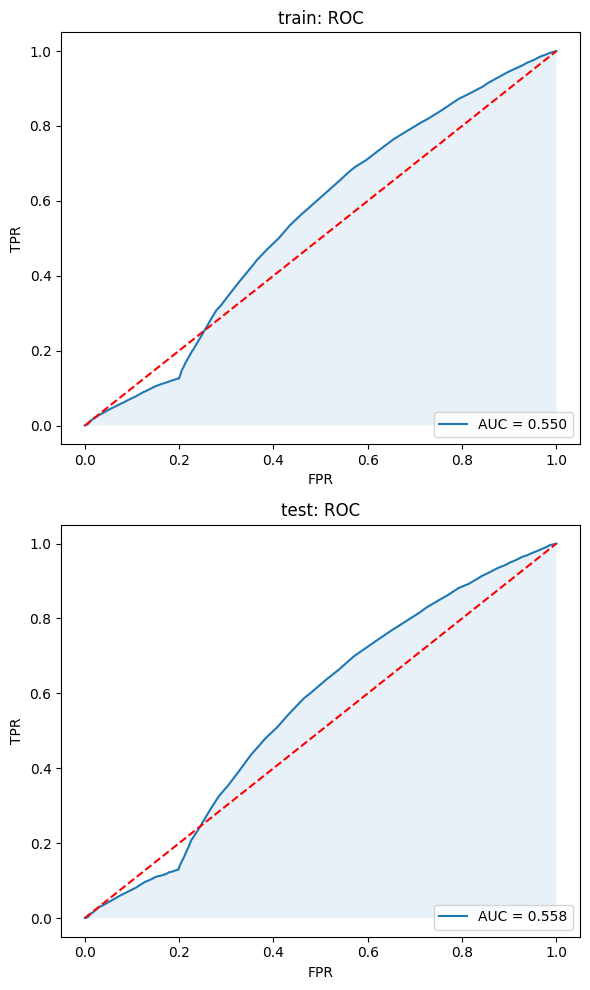

In [20]:
train_decision = -train_score
test_decision  = -test_score

# --- Compute ROC and AUC for train ---
fpr_train, tpr_train, _ = metrics.roc_curve(y_train, train_decision)
auc_train = metrics.roc_auc_score(y_train, train_decision)

# --- Compute ROC and AUC for test ---
fpr_test, tpr_test, _ = metrics.roc_curve(y_test, test_decision)
auc_test = metrics.roc_auc_score(y_test, test_decision)

print(f"Train AUC: {auc_train:.3f}")
print(f"Test  AUC: {auc_test:.3f}")

# --- Plot ROC curves (train + test) ---
fig, axes = plt.subplots(2, 1, figsize=(6, 10))

# Train ROC
axes[0].plot(fpr_train, tpr_train, label=f"AUC = {auc_train:.3f}")
axes[0].plot([0, 1], [0, 1], 'r--')  # random baseline
axes[0].set_title("train: ROC")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].fill_between(fpr_train, tpr_train, alpha=0.1)
axes[0].legend(loc="lower right")

# Test ROC
axes[1].plot(fpr_test, tpr_test, label=f"AUC = {auc_test:.3f}")
axes[1].plot([0, 1], [0, 1], 'r--')  # random baseline
axes[1].set_title("test: ROC")
axes[1].set_xlabel("FPR")
axes[1].set_ylabel("TPR")
axes[1].fill_between(fpr_test, tpr_test, alpha=0.1)
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

In [21]:
card

{'basepoints':      variable  bin  points
 0  basepoints  NaN       0,
 'DEBT_RATIO':      variable               bin  points
 0  DEBT_RATIO      [-inf,0.055)    77.0
 1  DEBT_RATIO     [0.055,0.352)    72.0
 2  DEBT_RATIO  [0.352,1426.867)    65.0
 3  DEBT_RATIO    [1426.867,inf)    37.0,
 'AMT_CREDIT':       variable                    bin  points
 4   AMT_CREDIT        [-inf,150000.0)    83.0
 5   AMT_CREDIT    [150000.0,270000.0)    76.0
 6   AMT_CREDIT    [270000.0,670000.0)    71.0
 7   AMT_CREDIT   [670000.0,1000000.0)    77.0
 8   AMT_CREDIT  [1000000.0,1300000.0)    80.0
 9   AMT_CREDIT  [1300000.0,4000000.0)    87.0
 10  AMT_CREDIT        [4000000.0,inf)    69.0,
 'OCCUPATION_TYPE':            variable                                                bin  points
 11  OCCUPATION_TYPE                                            missing    80.0
 12  OCCUPATION_TYPE  Accountants%,%HR staff%,%Core staff%,%High ski...    84.0
 13  OCCUPATION_TYPE  Realty agents%,%Sales staff%,%Cleanin

In [22]:
# combine all variable tables into one big dataframe
card_df = pd.concat(card.values(), ignore_index=True)

# show all rows (or set a big number)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

card_df

,variable,bin,points
0,basepoints,NaN,0.0
1,DEBT_RATIO,"[-inf,0.055)",77.0
2,DEBT_RATIO,"[0.055,0.352)",72.0
3,DEBT_RATIO,"[0.352,1426.867)",65.0
4,DEBT_RATIO,"[1426.867,inf)",37.0
5,AMT_CREDIT,"[-inf,150000.0)",83.0
6,AMT_CREDIT,"[150000.0,270000.0)",76.0
7,AMT_CREDIT,"[270000.0,670000.0)",71.0
8,AMT_CREDIT,"[670000.0,1000000.0)",77.0
9,AMT_CREDIT,"[1000000.0,1300000.0)",80.0
